In [34]:
# Imports
import sys, os
from Bio import Entrez
import json
from ete3 import NCBITaxa
import pandas as pd
from ete3 import Tree

In [35]:
# Declares
CSV_FILE = "../data/BDNF/BDNF_orthologs.csv"
#CSV_FILE = sys.argv[1]

DATA_DICT = {}

# The following looks up NCBI Taxon ID from Accession IDs
# Then uses that Taxon ID to get the complete taxnomic lineage of of that species.
Entrez.email = "aglucaci@gmail.com"


In [36]:
TREE_FILE = "../results/BDNF/Recombinants/BDNF_codons_RDP_recombinationFree.fas.treefile"

#TREE_FILE = sys.argv[2]

# Read file, get newick
with open(TREE_FILE, "r") as fh:
    TREE_NEWICK = fh.read()
#end with

In [37]:
TREE_NEWICK

'(NM_001709_5_Homo_sapiens_brain_derived_neurotrophi:0.0029488377,(((((((((((((((NM_001270630_1_Rattus_norvegicus_brain_derived_neu:0.0000012534,XM_032903861_1_PREDICTED_Rattus_rattus_brain_deriv:0.0042541155):0.0039513138,(((NM_001048142_1_Mus_musculus_brain_derived_neurotro:0.0000012534,XM_021151236_2_PREDICTED_Mus_caroli_brain_derived_:0.0028211013):0.0018641414,XM_021192829_2_PREDICTED_Mus_pahari_brain_derived_:0.0037938749):0.0090284995,XM_031371313_1_PREDICTED_Mastomys_coucha_brain_der:0.0109800869):0.0078256093):0.0104426925,(XM_007653166_4_PREDICTED_Cricetulus_griseus_brain_:0.0211728641,XM_037204438_1_PREDICTED_Peromyscus_leucopus_brain:0.0127118905):0.0101439859):0.0187471730,XM_029555090_1_PREDICTED_Nannospalax_galili_brain_:0.0166596988):0.0120065761,XM_004660846_2_PREDICTED_Jaculus_jaculus_brain_der:0.0877088541):0.0209003930,((XM_013019592_1_PREDICTED_Dipodomys_ordii_brain_der:0.0649145876,(((XM_015476449_1_PREDICTED_Marmota_marmota_marmota_b:0.0014228233,XM_027936596_1_P

In [38]:
df = pd.read_csv(CSV_FILE)
df.index += 1
df

,Gene ID,Gene symbol,Description,Scientific name,Common name,RefSeq Transcript accessions,RefSeq Protein accessions,SPARCLE ID,Curation Status,RefseqSelect,Default sequence
1,627,BDNF,brain derived neurotrophic factor,Homo sapiens,human,NM_001709.5,NP_001700.2,10639753.0,curated,RefseqSelect,default-seq
2,12064,Bdnf,brain derived neurotrophic factor,Mus musculus,house mouse,NM_001048142.1,NP_001041607.1,10639753.0,curated,RefseqSelect,default-seq
3,24225,Bdnf,brain-derived neurotrophic factor,Rattus norvegicus,Norway rat,NM_001270630.1,NP_001257559.1,10639753.0,curated,NaN,default-seq
4,397495,BDNF,brain derived neurotrophic factor,Sus scrofa,pig,XM_005654684.3,XP_005654741.1,10639753.0,model,NaN,default-seq
5,403461,BDNF,brain derived neurotrophic factor,Canis lupus familiaris,dog,XM_038429434.1,XP_038285362.1,NaN,model,NaN,default-seq
...,...,...,...,...,...,...,...,...,...,...,...
158,120876831,BDNF,brain derived neurotrophic factor,Oryx dammah,scimitar-horned oryx,XM_040258919.1,XP_040114853.1,NaN,model,NaN,default-seq
159,121043625,BDNF,brain derived neurotrophic factor,Puma yagouaroundi,jaguarundi,XM_040495572.1,XP_040351506.1,NaN,model,NaN,default-seq
160,121156520,BDNF,brain derived neurotrophic factor,Ochotona curzoniae,black-lipped pika,XM_040980297.1,XP_040836231.1,NaN,model,NaN,default-seq
161,121465693,Bdnf,brain derived neurotrophic factor,Microtus oregoni,creeping vole,XM_041679035.1,XP_041534969.1,NaN,model,NaN,default-seq


In [39]:
transcript_accessions = df['RefSeq Transcript accessions'].tolist()

#len(transcript_accessions)

In [40]:
# Helper function
def match_transcript_to_tree(TREE_NEWICK, accession):
    t = Tree(TREE_NEWICK, format=1)
    
    # uncomment to debug
    #print("# in 'match_transcript_to_tree'", accession)
    
    for leafname in t.get_leaf_names():
        if accession in leafname:
            # uncomment to debug
            #print("# Returning:", leafname)
            return leafname
        #end if
    #end for
#end match
    

In [41]:
def main(transcript_accessions):
    #DATA_DICT = {}
    global DATA_DICT, TREE_NEWICK
    count = 1
    for ACCESSION in transcript_accessions:
        #print("# Checking ACCESION:", ACCESSION)
        skip = False
        for i in DATA_DICT.keys():
            if ACCESSION == DATA_DICT[i]["ACCESSION"]:
                skip = True
                break
            #end if
        #end for
        if skip == True: 
            count += 1
            continue
        #end if
        
        try:
            handle = Entrez.esummary(db="nucleotide", id=ACCESSION, rettype="gb", retmode="text", retmax=1)
            records = Entrez.parse(handle)
        except Exception as e:
            print("# Error, sleeping", e)
            time.sleep(5)
            handle = Entrez.esummary(db="nucleotide", id=ACCESSION, rettype="gb", retmode="text", retmax=1)
            records = Entrez.parse(handle)
        #end try
        
        try:
            for record in records:
                TAXON_ID = record["TaxId"]
                
                print("#", count, "Processing transcript accession:", str(ACCESSION), "with NCBI Taxon ID:", str(TAXON_ID))
                ncbi = NCBITaxa()
                
                lineage = ncbi.get_lineage(TAXON_ID)
                # uncomment to debug
                #print(lineage) # returns a list of taxon id's
                
                names = ncbi.get_taxid_translator(lineage)
                # uncomment to debug
                #print(names) # translates the taxon id's into clade names
                
                # uncomment to debug
                #print("# ACCESSION:", ACCESSION)
                leafname = ""
                leafname = match_transcript_to_tree(TREE_NEWICK, ACCESSION.replace(".", "_"))
                
                # uncomment to debug
                #print(leafname)
                
                DATA_DICT[str(count)] = {"ACCESSION": ACCESSION, "TAXON_ID": TAXON_ID, 
                                         "LINEAGE": [names[taxid] for taxid in lineage], 
                                         "TITLE":record["Title"], "LEAFNAME": leafname}
                count += 1
            #end inner for
            handle.close
        except Exception as e:
            print("# Error (main):", ACCESSION, e, "\n")
            #print(names)
            #print(e)
            #main(TREE_NEWICK) # Recursive.
            #break
        #end try
        
    #end outer for
    
    #return DATA_DICT
#end method



In [42]:
main(transcript_accessions)

# 1 Processing transcript accession: NM_001709.5 with NCBI Taxon ID: IntegerElement(9606, attributes={})
# 2 Processing transcript accession: NM_001048142.1 with NCBI Taxon ID: IntegerElement(10090, attributes={})
# 3 Processing transcript accession: NM_001270630.1 with NCBI Taxon ID: IntegerElement(10116, attributes={})
# 4 Processing transcript accession: XM_005654684.3 with NCBI Taxon ID: IntegerElement(9823, attributes={})
# 5 Processing transcript accession: XM_038429434.1 with NCBI Taxon ID: IntegerElement(9615, attributes={})
# 6 Processing transcript accession: NM_001009828.1 with NCBI Taxon ID: IntegerElement(9685, attributes={})
# 7 Processing transcript accession: NM_001012441.1 with NCBI Taxon ID: IntegerElement(9598, attributes={})
# 8 Processing transcript accession: XM_007497196.2 with NCBI Taxon ID: IntegerElement(13616, attributes={})
# 9 Processing transcript accession: XM_005216334.4 with NCBI Taxon ID: IntegerElement(9913, attributes={})
# 10 Processing transcript a

# 76 Processing transcript accession: XM_010831788.1 with NCBI Taxon ID: IntegerElement(43346, attributes={})
# 77 Processing transcript accession: XM_010964743.1 with NCBI Taxon ID: IntegerElement(9837, attributes={})
# 78 Processing transcript accession: XM_031459858.1 with NCBI Taxon ID: IntegerElement(9838, attributes={})
# 79 Processing transcript accession: XM_011362565.2 with NCBI Taxon ID: IntegerElement(132908, attributes={})
# 80 Processing transcript accession: XM_011710310.2 with NCBI Taxon ID: IntegerElement(9545, attributes={})
# 81 Processing transcript accession: XM_011936307.1 with NCBI Taxon ID: IntegerElement(336983, attributes={})
# 82 Processing transcript accession: XM_011964715.1 with NCBI Taxon ID: IntegerElement(9568, attributes={})
# 83 Processing transcript accession: XM_012031697.1 with NCBI Taxon ID: IntegerElement(9531, attributes={})
# 84 Processing transcript accession: XM_012452238.1 with NCBI Taxon ID: IntegerElement(37293, attributes={})
# 85 Processi

# 151 Processing transcript accession: XM_037146035.1 with NCBI Taxon ID: IntegerElement(9417, attributes={})
# 152 Processing transcript accession: XM_037522538.1 with NCBI Taxon ID: IntegerElement(50954, attributes={})
# 153 Processing transcript accession: XM_037839114.1 with NCBI Taxon ID: IntegerElement(27675, attributes={})
# 154 Processing transcript accession: XM_038331579.1 with NCBI Taxon ID: IntegerElement(1047088, attributes={})
# 155 Processing transcript accession: XM_038764545.1 with NCBI Taxon ID: IntegerElement(9261, attributes={})
# 156 Processing transcript accession: XM_039217098.1 with NCBI Taxon ID: IntegerElement(95912, attributes={})
# 157 Processing transcript accession: XM_039866065.1 with NCBI Taxon ID: IntegerElement(143291, attributes={})
# 158 Processing transcript accession: XM_040258919.1 with NCBI Taxon ID: IntegerElement(59534, attributes={})
# 159 Processing transcript accession: XM_040495572.1 with NCBI Taxon ID: IntegerElement(1608482, attributes={}

In [43]:
# Check for errors here
print(len(transcript_accessions)) # Total
print(len(DATA_DICT.keys())) # What we have identified
# They need to match

162
162


In [44]:
df2 = pd.DataFrame.from_dict(DATA_DICT, orient="index")
#df2

In [45]:
#df2["LINEAGE"].to_list()

<AxesSubplot:ylabel='LINEAGE'>

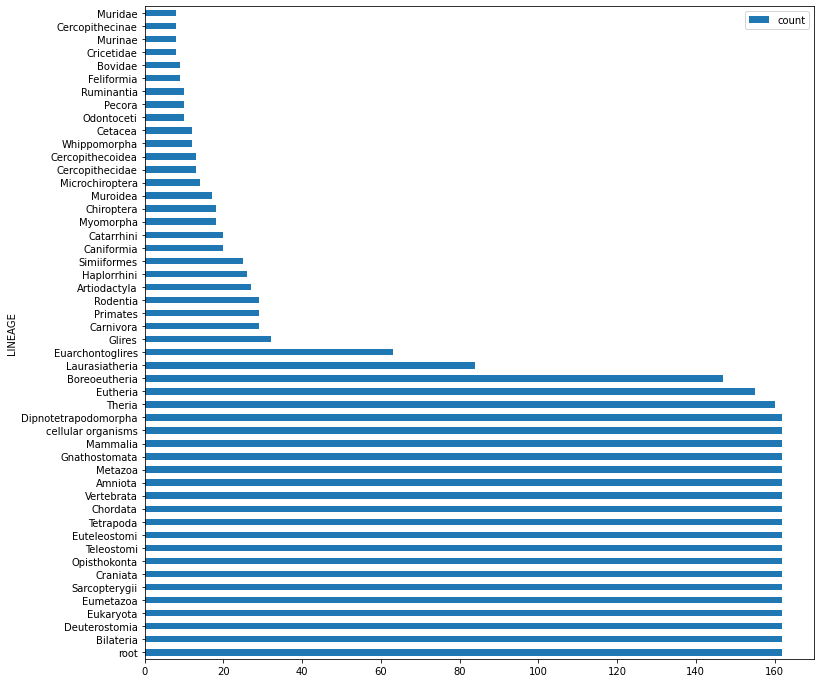

In [46]:
# use explode to expand the lists into separate rows
dfe = df2.LINEAGE.explode().to_frame().reset_index(drop=True)

## groupby the values in the column, get the count and sort
#dfg = dfe.groupby('LINEAGE').count() \
#                               .reset_index(name='count') \
#                               .sort_values(['count'], ascending=False) #

#display(dfg)
#dfg = dfe.groupby('LINEAGE').count().reset_index().sort_values(['count'], ascending=False) 
#dfg 

# plot the dataframe
#dfg.plot.bar(x='LINEAGE')

dfe

dfg = dfe.groupby('LINEAGE').LINEAGE.count() \
                               .reset_index(name='count') \
                               .sort_values(['count'], ascending=False) \
                               .head(50).reset_index(drop=True)

dfg.plot.barh(x='LINEAGE', figsize=(12, 12))


In [90]:
lineages = df2['LINEAGE'].tolist()

num_taxa = 20

for i in range(len(lineages[0])):
    to_add = []
    for species in lineages:
        to_add.append(species[i])
    #end inner for
    df2["Annotation"] = to_add
    a = df2["Annotation"].nunique()
    if a >= num_taxa: break
    print("#",i, "=", df2["Annotation"].nunique())
#end outer for



# 0 = 1
# 1 = 1
# 2 = 1
# 3 = 1
# 4 = 1
# 5 = 1
# 6 = 1
# 7 = 1
# 8 = 1
# 9 = 1
# 10 = 1
# 11 = 1
# 12 = 1
# 13 = 1
# 14 = 1
# 15 = 1
# 16 = 1
# 17 = 1
# 18 = 1
# 19 = 2
# 20 = 3
# 21 = 8
# 22 = 17


In [91]:
print(df2.groupby('Annotation').Annotation.count())
print(len(df2["Annotation"]))

Annotation
Artiodactyla                27
Carnivora                   29
Chiroptera                  18
Chrysochlorinae              1
Dasypodidae                  1
Dermoptera                   1
Didelphinae                  1
Elephantidae                 1
Eulipotyphla                 4
Folivora                     1
Glires                      32
Macroscelididae              1
Ornithorhynchus anatinus     1
Orycteropodidae              1
Perissodactyla               4
Phascolarctos                1
Pholidota                    2
Primates                    29
Sarcophilus                  1
Scandentia                   1
Tachyglossus aculeatus       1
Tenrecinae                   1
Trichechidae                 1
Trichosurus                  1
Vombatus                     1
Name: Annotation, dtype: int64
162


In [86]:
def optimize_lineages(df2, seed=5):
    # no lineage should be >= 40% of species.
    
    lineages = df2['LINEAGE'].tolist()
    
    num_taxa = seed
    
    print("## Seed =", seed)
    
    for i in range(len(lineages[0])):
        to_add = []
        for species in lineages:
            to_add.append(species[i])
        #end inner for
        
        df2["Annotation"] = to_add
        a = df2["Annotation"].nunique()
        if a >= num_taxa: 
            break
            
        #print("#",i, "=", df2["Annotation"].nunique())
    #end outer for
    
    # Do a check here.
    threshold = 0.4
    total = len(df2["Annotation"].tolist())

    for item in df2.groupby('Annotation').Annotation.count():
        calc = item / total
        print(calc)
        if calc > threshold:
            print(item / total, "exceeded threshold") 
            seed += 1
            optimize_lineages(df2, seed)
        else:
            pass
        #end if
    #end for
    # if it fails, make this recursive.
    # If we make it here, success
    
    print("# final seed =", seed)
    
    return df2
#end method

df2 = optimize_lineages(df2)

## Seed = 5
0.037037037037037035
0.9074074074074074
0.9074074074074074 exceeded threshold
## Seed = 6
0.037037037037037035
0.9074074074074074
0.9074074074074074 exceeded threshold
## Seed = 7
0.037037037037037035
0.9074074074074074
0.9074074074074074 exceeded threshold
## Seed = 8
0.037037037037037035
0.9074074074074074
0.9074074074074074 exceeded threshold
## Seed = 9
0.006172839506172839
0.006172839506172839
0.006172839506172839
0.006172839506172839
0.3888888888888889
0.5185185185185185
0.5185185185185185 exceeded threshold
## Seed = 10
0.006172839506172839
0.006172839506172839
0.006172839506172839
0.006172839506172839
0.3888888888888889
0.5185185185185185
0.5185185185185185 exceeded threshold
## Seed = 11
0.006172839506172839
0.006172839506172839
0.006172839506172839
0.006172839506172839
0.3888888888888889
0.5185185185185185
0.5185185185185185 exceeded threshold
## Seed = 12
0.006172839506172839
0.006172839506172839
0.006172839506172839
0.006172839506172839
0.3888888888888889
0.5185

In [83]:
df2['LINEAGE'].tolist()

[['root',
  'cellular organisms',
  'Eukaryota',
  'Opisthokonta',
  'Metazoa',
  'Eumetazoa',
  'Bilateria',
  'Deuterostomia',
  'Chordata',
  'Craniata',
  'Vertebrata',
  'Gnathostomata',
  'Teleostomi',
  'Euteleostomi',
  'Sarcopterygii',
  'Dipnotetrapodomorpha',
  'Tetrapoda',
  'Amniota',
  'Mammalia',
  'Theria',
  'Eutheria',
  'Boreoeutheria',
  'Euarchontoglires',
  'Primates',
  'Haplorrhini',
  'Simiiformes',
  'Catarrhini',
  'Hominoidea',
  'Hominidae',
  'Homininae',
  'Homo',
  'Homo sapiens'],
 ['root',
  'cellular organisms',
  'Eukaryota',
  'Opisthokonta',
  'Metazoa',
  'Eumetazoa',
  'Bilateria',
  'Deuterostomia',
  'Chordata',
  'Craniata',
  'Vertebrata',
  'Gnathostomata',
  'Teleostomi',
  'Euteleostomi',
  'Sarcopterygii',
  'Dipnotetrapodomorpha',
  'Tetrapoda',
  'Amniota',
  'Mammalia',
  'Theria',
  'Eutheria',
  'Boreoeutheria',
  'Euarchontoglires',
  'Glires',
  'Rodentia',
  'Myomorpha',
  'Muroidea',
  'Muridae',
  'Murinae',
  'Mus',
  'Mus',
  

In [87]:
df2

,ACCESSION,TAXON_ID,LINEAGE,TITLE,LEAFNAME,Annotation
1,NM_001709.5,9606,"[root, cellular organisms, Eukaryota, Opisthok...",Homo sapiens brain derived neurotrophic factor...,NM_001709_5_Homo_sapiens_brain_derived_neurotr...,Primates
2,NM_001048142.1,10090,"[root, cellular organisms, Eukaryota, Opisthok...",Mus musculus brain derived neurotrophic factor...,NM_001048142_1_Mus_musculus_brain_derived_neur...,Glires
3,NM_001270630.1,10116,"[root, cellular organisms, Eukaryota, Opisthok...",Rattus norvegicus brain-derived neurotrophic f...,NM_001270630_1_Rattus_norvegicus_brain_derived...,Glires
4,XM_005654684.3,9823,"[root, cellular organisms, Eukaryota, Opisthok...",PREDICTED: Sus scrofa brain derived neurotroph...,XM_005654684_3_PREDICTED_Sus_scrofa_brain_deri...,Artiodactyla
5,XM_038429434.1,9615,"[root, cellular organisms, Eukaryota, Opisthok...",PREDICTED: Canis lupus familiaris brain derive...,XM_038429434_1_PREDICTED_Canis_lupus_familiari...,Carnivora
...,...,...,...,...,...,...
158,XM_040258919.1,59534,"[root, cellular organisms, Eukaryota, Opisthok...",PREDICTED: Oryx dammah brain derived neurotrop...,XM_040258919_1_PREDICTED_Oryx_dammah_brain_der...,Artiodactyla
159,XM_040495572.1,1608482,"[root, cellular organisms, Eukaryota, Opisthok...",PREDICTED: Puma yagouaroundi brain derived neu...,None,Carnivora
160,XM_040980297.1,130825,"[root, cellular organisms, Eukaryota, Opisthok...",PREDICTED: Ochotona curzoniae brain derived ne...,XM_040980297_1_PREDICTED_Ochotona_curzoniae_br...,Glires
161,XM_041679035.1,111838,"[root, cellular organisms, Eukaryota, Opisthok...",PREDICTED: Microtus oregoni brain derived neur...,None,Glires


In [71]:
threshold = 0.4
total = len(df2["Annotation"].tolist())

for item in df2.groupby('Annotation').Annotation.count():
    calc = item / total
    print(item / total)
    if calc > threshold:
        print(item / total, "exceeded threshold") 
    

0.037037037037037035
0.9074074074074074
0.9074074074074074 exceeded threshold
0.006172839506172839
0.006172839506172839
0.018518518518518517
0.006172839506172839
0.006172839506172839
0.012345679012345678


In [65]:
len(df2["Annotation"].tolist())

162

<AxesSubplot:ylabel='Annotation'>

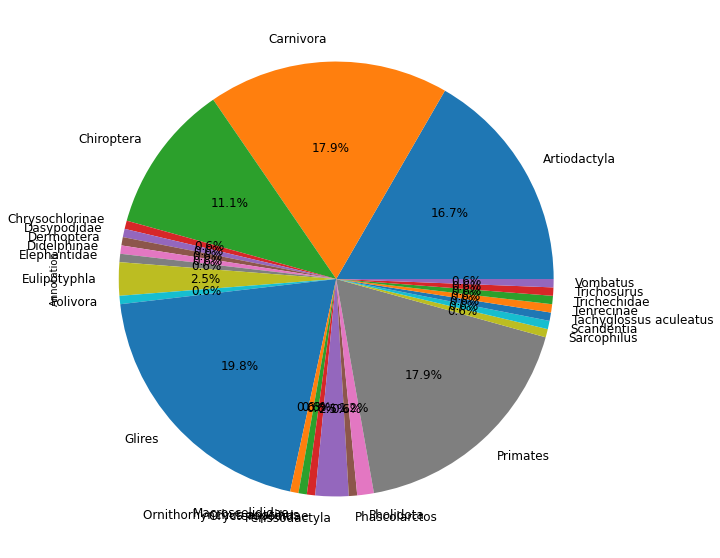

In [88]:

df2.groupby('Annotation').Annotation.count().plot.pie(figsize=(10, 10), autopct='%1.1f%%', fontsize=12)

In [89]:
df2.groupby('Annotation').Annotation.count()

Annotation
Artiodactyla                27
Carnivora                   29
Chiroptera                  18
Chrysochlorinae              1
Dasypodidae                  1
Dermoptera                   1
Didelphinae                  1
Elephantidae                 1
Eulipotyphla                 4
Folivora                     1
Glires                      32
Macroscelididae              1
Ornithorhynchus anatinus     1
Orycteropodidae              1
Perissodactyla               4
Phascolarctos                1
Pholidota                    2
Primates                    29
Sarcophilus                  1
Scandentia                   1
Tachyglossus aculeatus       1
Tenrecinae                   1
Trichechidae                 1
Trichosurus                  1
Vombatus                     1
Name: Annotation, dtype: int64

In [ ]:
# Old way seed = 20

Artiodactyla                27
Carnivora                   29
Chiroptera                  18
Chrysochlorinae              1
Dasypodidae                  1
Dermoptera                   1
Didelphinae                  1
Elephantidae                 1
Eulipotyphla                 4
Folivora                     1
Glires                      32
Macroscelididae              1
Ornithorhynchus anatinus     1
Orycteropodidae              1
Perissodactyla               4
Phascolarctos                1
Pholidota                    2
Primates                    29
Sarcophilus                  1
Scandentia                   1
Tachyglossus aculeatus       1
Tenrecinae                   1
Trichechidae                 1
Trichosurus                  1
Vombatus                     1
Name: Annotation, dtype: int64
162

array([<AxesSubplot:ylabel='Annotation'>], dtype=object)

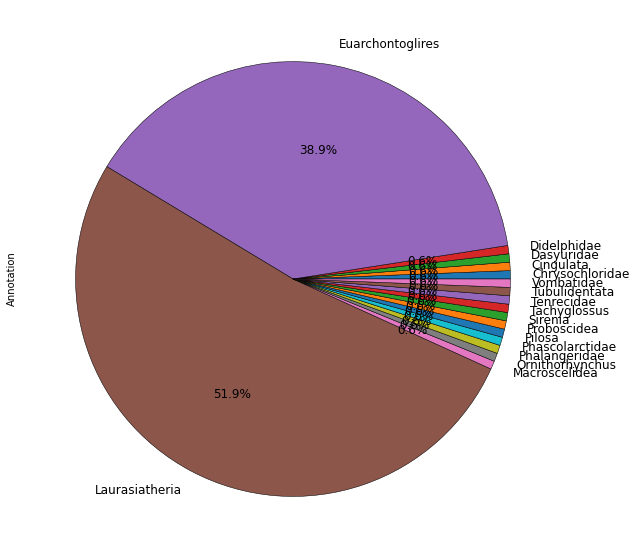

In [51]:
df2.groupby('Annotation').Annotation.count().plot.pie(figsize=(10, 10), autopct='%1.1f%%', fontsize=12, subplots=True, wedgeprops={"edgecolor":"0",'linewidth': 0.5})

In [52]:
for item in set(df2["Annotation"].to_list()):
    #print(item)
    df3 = df2[df2["Annotation"] == item]
    #print(df3)
    df3 = df3.dropna()
    
    #if len(df3["ACCESSION"].to_list()) < 3: 
    #    continue
    
    #print(df3["LEAFNAME"].to_list())
    #df3.to_csv(item + ".csv", index=True)
    
    print("# Saving", str(len(df3["LEAFNAME"].to_list())), "to:", item + ".clade")
    with open(item + ".clade", "w") as fh:
        fh.write("\n".join(df3["LEAFNAME"].to_list()))
        #for row in df3["LEAFNAME"].to_list():
        #    fh.write(row)

# Saving 49 to: Euarchontoglires.clade
# Saving 0 to: Proboscidea.clade
# Saving 1 to: Didelphidae.clade
# Saving 1 to: Macroscelidea.clade
# Saving 1 to: Tenrecidae.clade
# Saving 1 to: Tachyglossus.clade
# Saving 1 to: Chrysochloridae.clade
# Saving 1 to: Tubulidentata.clade
# Saving 1 to: Phalangeridae.clade
# Saving 1 to: Pilosa.clade
# Saving 1 to: Ornithorhynchus.clade
# Saving 1 to: Dasyuridae.clade
# Saving 63 to: Laurasiatheria.clade
# Saving 1 to: Vombatidae.clade
# Saving 1 to: Cingulata.clade
# Saving 1 to: Phascolarctidae.clade
# Saving 1 to: Sirenia.clade


In [53]:
df3["Annotation"]

30    Sirenia
Name: Annotation, dtype: object

In [54]:
# There may be errors above, some LEAFNAMEs do not populate. Check the search for subroutine to make sure it works.